<a href="https://colab.research.google.com/github/JinXianWen95/PyTorch-bootcamp/blob/main/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Paper Replicating

The goal of machine learning research paper replicating is : turn a ML reasearch paper into usable code.

We're going to be replicating the Vision Transfromer (ViT) architecture/paper with PyTorch. https://arxiv.org/abs/2010.11929

## 0. Setup

In [ ]:
import torch
import torchvision

print(torch.__version__) #want 1.12+
print(torchvision.__version__) # want 0.13+

from google.colab import drive
import sys

drive.mount('/content/drive')

# Define the path to your scripts folder
script_path = '/content/drive/MyDrive/colab_copilot_data/05/scripts'

# Add it to sys.path if it's not already there
if script_path not in sys.path:
    sys.path.append(script_path)

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.9.0+cu128
0.24.0+cu128
Mounted at /content/drive
[INFO] Couldn't find torchinfo... installing it.


'cuda'

In [ ]:
!nvidia-smi

Sun Feb 15 16:41:43 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             15W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from pathlib import Path
import helper_functions
import data_setup
from torch import nn
from torchvision.transforms import v2

image_path = helper_functions.download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="/content/drive/MyDrive/colab_copilot_data/04/data/pizza_steak_sushi")

data_path = Path("/content/drive/MyDrive/colab_copilot_data/04/data/")
image_path = data_path / "pizza_steak_sushi"

train_dir = image_path / "train"
test_dir = image_path / "test"

IMG_SIZE = 224 # the paper training resolution is 224
BATCH_SIZE = 32 # On paper it's 4096, but we don't have powerfull machine

manual_transforms = v2.Compose([
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.ToTensor()
])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

[INFO] /content/drive/MyDrive/colab_copilot_data/04/data/pizza_steak_sushi directory exists, skipping download.


/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


torch.Size([3, 224, 224]) tensor(0)


Text(0.5, 1.0, 'pizza')

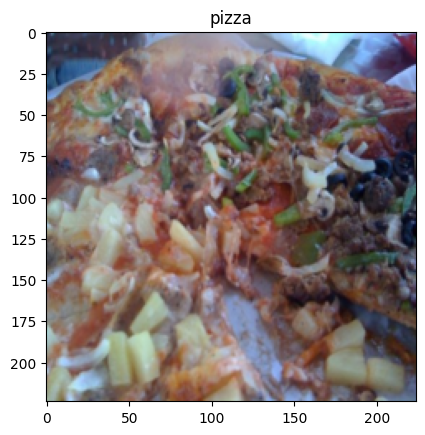

In [ ]:
import matplotlib.pyplot as plt
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
print(image_batch[0].shape, label_batch[0])

plt.imshow(image_batch[0].permute(1, 2, 0))
plt.title(class_names[label_batch[0]])

## 1. Replicating ViT: Overview

Looking at a whole ML research paper can be intimidating. In order to make it more understandable we can break it down into smaller parts:
* **Inputs** - What goes into the model? -> image tensors
* **Outputs** - Waht comes out of the model/layer/block? -> image classification labels
* **Layers** -  Takes an input, manipulates it with a function (for example self-attention)
* **Blocks** - A collection of layers
* **Model (or architecture)** -  A collection of blocks

### 1.1 ViT overview: pieces of the puzzle
* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the function of each layer/block
* Table 1/3: different hyperparametes for the architecture/training

https://www.learnpytorch.io/08_pytorch_paper_replicating/#0-getting-setup


* Embedding = learnable representation

## 2. Equation 1: Split data into patches and creating the class, position and patch embedding

Layer = input -> function -> output

What's the input shape? -> $H \times W \times C$

What's the output shape? -> ${N\times (P^2 \cdot C)}$

In [ ]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height * width) / patch_size**2)

embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number of patches, embedding_dimension)')

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number of patches, embedding_dimension)


### 2.1 Turning a single image into patches

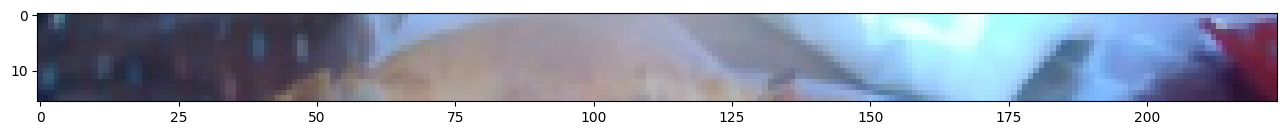

In [ ]:
# Get the top row of the image
image_permuted = image.permute(1,2,0) # (H,W,C)

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

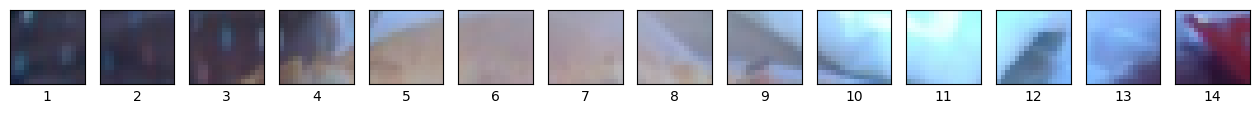

In [ ]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size)) # one column for each patch

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


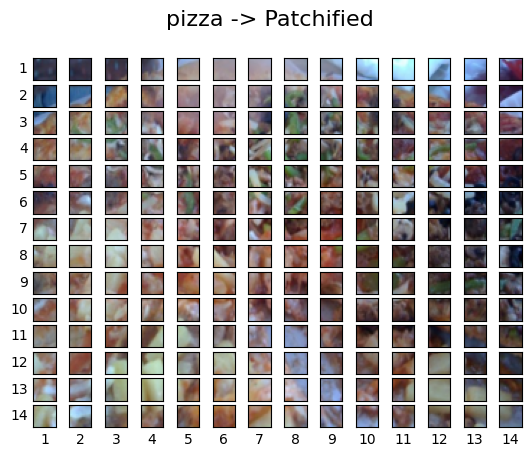

In [ ]:
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True) # one column for each patch

print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Iterate through number of patches in the top row
for i, x_patch in enumerate(range(0, img_size, patch_size)):
  for j, y_patch in enumerate(range(0, img_size, patch_size)):
    axs[i, j].imshow(image_permuted[x_patch:x_patch+patch_size, y_patch:y_patch+patch_size, :])
    axs[i, j].set_ylabel(i+1,
                        rotation="horizontal",
                        horizontalalignment="right",
                        verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### 2.2 Creating image patches and turning them into patch embeddings

We could create the image patchs and image patch embeddings in a single step with conv2d layer using `kernel_size` and `stride` same as patch size

torch.Size([1, 768, 14, 14])
tensor([[[-6.6890e-03,  1.7823e-02, -3.9330e-03,  ...,  5.5305e-02,
          -4.5455e-02, -3.2148e-02],
         [-6.3130e-02, -8.1855e-02,  4.2666e-02,  ...,  1.2106e-01,
          -7.3980e-02, -1.1278e-01],
         [ 7.2975e-02,  1.0068e-01, -1.9149e-02,  ...,  6.2865e-03,
           4.8626e-02,  1.8098e-01],
         ...,
         [ 6.2772e-02,  2.0850e-02, -8.7638e-02,  ...,  1.9355e-02,
           6.6515e-02,  2.9732e-02],
         [-3.9823e-02,  1.8017e-01,  7.8812e-02,  ..., -3.9672e-04,
          -1.5570e-02, -9.2214e-03],
         [ 4.7965e-02,  6.7976e-02,  7.9288e-02,  ...,  6.7217e-02,
           1.0511e-01, -1.2490e-03]],

        [[-8.6789e-02, -9.7092e-02, -7.5295e-02,  ..., -3.1027e-01,
          -3.1096e-01, -3.6724e-01],
         [ 8.8611e-03, -2.8007e-03, -3.0615e-01,  ..., -4.2514e-01,
          -1.9079e-01,  3.0471e-01],
         [-2.9482e-01, -2.4605e-01, -1.4936e-01,  ..., -9.9873e-02,
          -1.2839e-01, -3.2372e-01],
         .

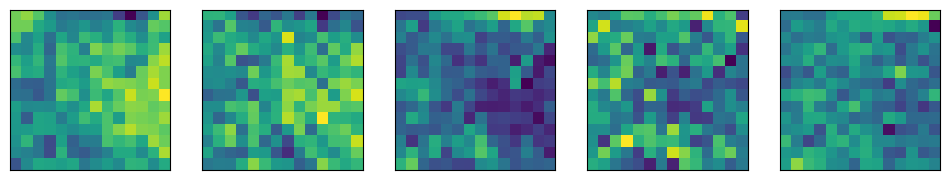

In [ ]:
# conv2d layer
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3, # color channel
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0).to(device) # D

image_out_of_conv = conv2d(image.unsqueeze(0).to(device)) # add batch dimension
print(image_out_of_conv.shape)
print(image_out_of_conv[0])

# plot random conv feature maps
import random
random_indexes = random.sample(range(0, 758), k = 5)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().cpu().detach().numpy()) # squeeze to delete batch dimension
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [ ]:
# Get a single feature map
single_feature_map = image_out_of_conv[:, 0, :, :]
print(single_feature_map)

tensor([[[-0.0067,  0.0178, -0.0039,  0.1663,  0.0762,  0.0447,  0.0611,
           0.0124,  0.1166,  0.1275,  0.0594,  0.0553, -0.0455, -0.0321],
         [-0.0631, -0.0819,  0.0427,  0.1163,  0.0753,  0.0448,  0.0436,
           0.0797, -0.0201,  0.0817,  0.1780,  0.1211, -0.0740, -0.1128],
         [ 0.0730,  0.1007, -0.0191, -0.0133,  0.0535,  0.0479, -0.0122,
           0.0145,  0.0363, -0.0154, -0.0166,  0.0063,  0.0486,  0.1810],
         [ 0.0407,  0.0284,  0.1071,  0.0400, -0.0051,  0.0018,  0.0740,
           0.0997,  0.1595,  0.1089,  0.0392,  0.1116,  0.0315, -0.0198],
         [ 0.0674,  0.0083,  0.0494, -0.0626,  0.1360,  0.1532,  0.0644,
          -0.1463,  0.0350, -0.0195,  0.0180, -0.1026, -0.0556, -0.0259],
         [ 0.0331,  0.0646, -0.0131,  0.0336, -0.0463,  0.0294, -0.0170,
          -0.0125,  0.1014,  0.2106,  0.1500,  0.1818, -0.0740, -0.1185],
         [ 0.0326,  0.0609,  0.0254,  0.0777,  0.0153,  0.1315, -0.0317,
          -0.0180, -0.0277,  0.0745, -0.1027,

### 2.3 Flattening the patch embedding

We have a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence to satisfy the input criteria of the ViT Transformer Encoder

In [ ]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [ ]:
# We want to flatten 14x14, not the whole tensor
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


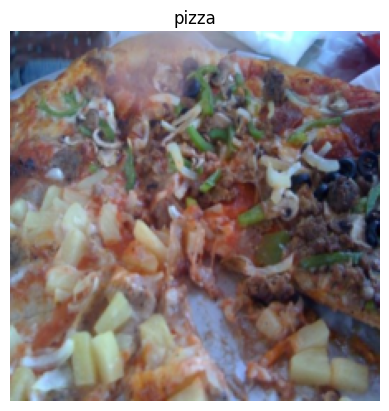

In [ ]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0).to(device)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [ ]:
# Rearrange output of flattened layer to have (batch_size, embedding, )
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


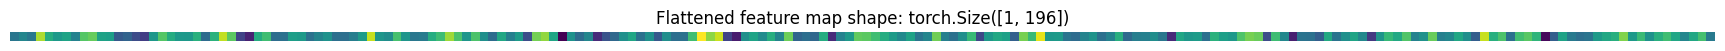

In [ ]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.cpu().detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

### 2.4 Turning the ViT patch embedding layer into PyTorch module

1. Create a class called PatchEmbedding which subclasses nn.Module (so it can be used a PyTorch layer).
2. Initialize the class with the parameters in_channels=3, patch_size=16 (for ViT-Base) and embedding_dim=768 (this is $D$ for ViT-Base from Table 1).
3. Create a layer to turn an image into patches using `nn.Conv2d()`.
4. Create a layer to flatten the patch feature maps into a single dimension.
5. Define a forward() method to take an input and pass it through the layers created in 3 and 4.
6. Make sure the output shape reflects the required output shape of the ViT architecture ${N \times\left(P^{2} \cdot C\right)}$.

In [ ]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x.to(device))
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [ ]:
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768).to(device)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0).to(device)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


### 2.5 Creating the class token embedding

Want to prepend a learnable class token to the start of the patch embedding.

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), requires_grad=True).to(device)
print(class_token.shape)
print(class_token)

# add class token to patch embedding
print(patch_embedded_image.device)
patch_embedded_image_with_class = torch.cat((class_token, patch_embedded_image),
                                            dim=1) # number of patches dimension
print(patch_embedded_image_with_class.shape)
print(patch_embedded_image_with_class)

torch.Size([1, 1, 768])
tensor([[[-7.5778e-01,  1.5136e-01,  2.3032e-01, -3.2983e+00, -9.9048e-01,
          -9.5202e-01,  8.2125e-02, -8.9045e-01, -8.0144e-01,  4.2918e-01,
           1.3133e+00, -4.5648e-01, -1.7510e+00, -3.8494e-01, -2.1991e-01,
          -5.0411e-01,  1.4079e+00, -8.9040e-01,  5.0614e-01, -1.5139e+00,
           1.4579e-01,  6.8029e-01,  1.1233e+00, -6.7681e-01,  7.2580e-01,
          -1.0023e+00, -1.1688e+00, -1.2531e+00, -5.7556e-01,  2.4490e+00,
          -1.1793e+00,  7.6457e-01,  2.1489e-01, -5.7893e-01, -7.9991e-02,
          -5.3560e-01,  1.6091e-02,  8.0752e-01, -2.2474e+00, -9.3431e-01,
           5.1470e-02,  1.2131e+00,  3.5082e-01,  2.2855e+00, -6.9654e-01,
           6.0384e-01, -5.1335e-01, -8.5532e-01,  1.4655e-01, -5.3521e-01,
           4.0015e-01, -1.2450e-01,  7.9781e-01,  1.7917e+00,  3.7240e-01,
          -2.9484e-01,  1.2917e-01,  1.4581e+00,  7.5237e-01, -1.1956e+00,
           9.1173e-01,  2.8429e+00,  8.2539e-01,  1.0373e+00,  1.4212e-02,
 

### 2.6 Creating the position embedding

Create a series of 1D learnable position embeddings and add them to the sequence of pacth embeddings

In [ ]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
embedding_dimension = patch_embedded_image_with_class.shape[-1]

position_embedding = nn.Parameter(torch.randn(batch_size, number_of_patches+1, embedding_dimension), requires_grad=True).to(device)
print(position_embedding.shape)

# Add the position embedding to the pacth and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class + position_embedding
print(patch_and_position_embedding.shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


### 2.7 Putting it all together: from image to embedding

In [ ]:
# 1. set patch_size
patch_size = 16

# 2. Print shapes of the original image tensor
print(f'Image tensor shape: {image.shape}')
height, width = image.shape[1], image.shape[2]

# 3. add batch dimension
x = image.unsqueeze(0)
print(f'Input image shape: {x.shape}')

# 4. create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768).to(device)

# 5. Pass the input image to patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f'Patch embedding shape: {patch_embedding.shape}')

# 6. Create class token embedding ad preappend it to patch embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), requires_grad=True).to(device)
patch_embedded_image_with_class = torch.cat((class_token, patch_embedded_image),
                                            dim=1)
print(f'Patch embedding with class shape: {patch_embedded_image_with_class.shape}')

# 7. Create position embedding and add it to the patch embeddding with class
number_of_patches = int((height * width) / patch_size**2)
embedding_dimension = patch_embedded_image_with_class.shape[-1]
position_embedding = nn.Parameter(torch.randn(batch_size, number_of_patches+1, embedding_dimension), requires_grad=True).to(device)

patch_and_position_embedding = patch_embedded_image_with_class + position_embedding
print(f'patch_and_position_embedding shape: {patch_and_position_embedding.shape}')


Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Patch embedding with class shape: torch.Size([1, 197, 768])
patch_and_position_embedding shape: torch.Size([1, 197, 768])


## 3. Equation 2: Multihead Self-Attention (MSA block)
* Multihead self-attention: which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want the ViT to learn the relationship/representation

* Layer Normalization is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training. It helps improve training time and model generalization (ability to adapt to unseen data).
  * Normalization = make everything have the same mean and same standard deviation

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Creates a multi-head self-attention block ("MSA block" for short)."""
  def __init__(self,
               num_heads:int=12, # heads from paper
               embedding_dim:int=768,
               attn_dropout:float=0):
    super().__init__()

    self.multihead_self_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                          num_heads=num_heads,
                                                          dropout=attn_dropout,
                                                          batch_first=True) # (batch, seq, feature) instead of (seq, batch, feature)

    self.norm_layer = nn.LayerNorm(normalized_shape=embedding_dim)

  def forward(self, x):
    x_normalized = self.norm_layer(x.to(device))
    x_self_attention, _ = self.multihead_self_attention(
        query=x, # query embeddings
        key=x, # key embeddings
        value=x, # value embeddings
        need_weights=False)

    return x_self_attention

In [ ]:
msa_layer = MultiHeadSelfAttentionBlock().to(device)
msa_output = msa_layer(patch_and_position_embedding) + patch_and_position_embedding
print(msa_output.shape)
print(msa_output[:, 0, :])

torch.Size([1, 197, 768])
tensor([[ 1.9067e+00, -2.7198e+00,  1.8790e-01, -2.3161e+00, -1.4174e+00,
         -4.3976e-01,  1.4165e+00, -2.6012e-01,  1.1058e+00,  9.9555e-01,
          1.8300e+00,  4.1006e-02,  4.0011e-01, -4.8970e-01, -1.1230e+00,
         -3.3058e-01,  1.8895e+00, -1.7712e+00, -2.1092e+00, -9.5950e-01,
         -2.0065e+00, -1.0546e+00,  5.3399e-01,  1.1864e+00, -7.8060e-01,
          2.8349e+00, -8.7158e-01,  7.7545e-01, -2.2294e+00, -1.5102e+00,
          1.2162e-01,  1.1205e+00,  9.8478e-01,  1.3501e+00,  8.4607e-01,
          4.4166e-01, -5.4586e-03, -2.9846e-01,  6.3866e-01,  2.1792e+00,
          4.9073e-01, -8.8763e-01,  1.3313e+00, -1.7653e+00, -1.3309e-01,
          2.3244e-01, -1.7997e+00,  1.3448e+00,  1.2339e+00, -2.4066e+00,
          5.0106e-01,  5.7529e-01, -2.6606e+00, -3.6977e-01,  1.6109e+00,
         -2.1657e+00, -7.7809e-01, -1.4196e+00, -3.4244e+00,  1.0432e+00,
          2.8266e-01,  3.5607e-01, -2.5020e-01, -2.8774e-01, -9.0847e-01,
          7.

## 4. Equation 3: Multi Layer Perceptron (MLP)

* **MLP** = The MLP contains two layers with a GELU non-linearity
  * MLP = a broad term for a block with a multiple layers
  * Layers can mesn: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch it usually refers to `nn.Linear()`

In [ ]:
class MLPBlock(nn.Module):
  """Creates a MLP layer."""
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072, # hidden units
               dropout:float=0.1): # from paper
    super().__init__()

    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                  out_features=embedding_dim), # take back to embedding_dim
        nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
    )

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

  def forward(self, x):
    x = self.layer_norm(x.to(device))
    x = self.mlp(x)
    return x

In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1).to(device) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(msa_output)
print(f"Input shape of MLP block: {msa_output.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## 5. Creating the transform Encoder

The transformer encoder is a ombination of alternating blocks of MSA and MLP.

And there are residual connections between each block.

* Encoder =. turn a sequence into learnable representation
* Decoder = go from learn representation back to some sort of sequence
* Residual connections = add a layer(s) input to its usbsequent output, this enables the creation of deeper networks (prevents weights from getting too small)

### 5.1 Create a custom transformer encoder

In [ ]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0, # Amount of dropout for attention layers
                 ):
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x.to(device)) + x.to(device)

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [ ]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock().to(device)

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)            [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)                    [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (norm_layer)                                [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_self_attention)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                                [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                      [1, 197, 768]        [1, 197, 7

### 5.1 Create a Transformer Encoder with in-built PyTorch layers

* Is optimized with respect to our custom one

In [ ]:
torch_transformer_encoder = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation="gelu",
    batch_first=True,
    norm_first=True
).to(device)

summary(model=torch_transformer_encoder,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

## 6. Putting it all together to create ViT

In [ ]:
# Create Vit class
class ViT(nn.Module):
  def __init__(self,
              img_size:int=224, # Table 3 from ViT paper
              in_channels:int=3,
              patch_size:int=16,
              num_transformer_layers:int=12, # Table 1 for "Layers" for Vit-Base
              embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
              num_heads:int=12, # Heads from Table 1 for ViT-Base
              mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
              mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
              attn_dropout:float=0,
              embedding_dropout:int=0.1,
              num_classes:int=1000
              ):
    super().__init__()
    # Image size must be compatible with the patch size
    assert img_size % patch_size == 0, "Image size must be divisible by patch size"

    # Calculate number of patches
    self.number_of_patches = (img_size // patch_size) ** 2

    # Create class embedding
    self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim), requires_grad=True)

    # Create the position embedding
    self.position_embedding = nn.Parameter(torch.randn(1, self.number_of_patches+1, embedding_dim), requires_grad=True)

    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create the patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                          patch_size=patch_size,
                          embedding_dim=embedding_dim)

    # Create the transformer encoder
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    # 10. Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):

    batch_size = x.shape[0]

    #Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension

    # Create patch embedding (equation 1)
    x = self.patch_embedding(x.to(device))

    # Concat class embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1) # (batch_size, numer_of_patches, embedding_dim)

    # Add position embedding to patch embedding (equation 1)
    x = self.position_embedding + x

    # Run embedding dropout (Appendix B.1)
    x = self.embedding_dropout(x)

    # Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
    x = self.transformer_encoder(x)

    # Put 0 index logit through classifier (equation 4)
    x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

    return x

In [ ]:
vit = ViT()

summary(model=vit,
        input_size=(1, 3, 224, 224), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                              [1, 3, 224, 224]     [1, 1000]            152,064              True
├─PatchEmbedding (patch_embedding)                                     [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                                [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                               [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                          [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                                     [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderB

In [ ]:
random_image_tensor = torch.randn(1, 3, 224, 224).to(device)

vit = ViT(num_classes=3).to(device)
print(vit(random_image_tensor))
summary(model=vit,
        input_size=(1, 3, 224, 224), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

tensor([[0.8325, 0.1885, 0.5841]], device='cuda:0', grad_fn=<AddmmBackward0>)


Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                              [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                                     [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                                [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                               [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                          [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                                     [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderB

## 7. Setting up training code for ViT

We've replicated the ViT architecture, now let's see how it performs on the FoodVision Mini data

### 7.1 Creating Loss Function and Optimizer

The paper states it uses the Adam optimizer (section 4, Training & fine-tuning) with $B_1=0.9$ and $B_2=0.9999$ and a weight decay of 0.1.

Weight decay = Weight decay is a regularization technique by adding a small panalty, usually the L2 norm of the weights to the loss function

In [ ]:
# From paper
optimizer = torch.optim.Adam(
  vit.parameters(),
  lr=1e-3,
  betas=(0.9,0.999),
  weight_decay=0.1
)

# Loss function is not mentioned, we assume
loss_fn = torch.nn.CrossEntropyLoss()

### 7.2 Training the ViT model

In [ ]:
import engine

results = engine.train(
    model = vit,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = 5,
    device=device,
    writer=None
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.9369 | train_acc: 0.4336 | test_loss: 5.9969 | test_acc: 0.2604
Epoch: 2 | train_loss: 2.8343 | train_acc: 0.2461 | test_loss: 1.3200 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.2276 | train_acc: 0.4375 | test_loss: 1.0100 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.1786 | train_acc: 0.3984 | test_loss: 1.3015 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1306 | train_acc: 0.4141 | test_loss: 1.6279 | test_acc: 0.2604


### 7.3 What our training setup is missing

The original ViT paper uses a far larger amount of data than ours (in deep learning, more data is generally always a good thing) and a longer training schedule.

* Data - 225 vs millions
* Learning rate warmup - start with low learning rate and increase to a base LR
* Learning rate decay - as the model gets cloeser to convergence, start to lower the learning rate
* Gradient clipping - prevent gredients from getting too big

### 7.4 Plot loss curve

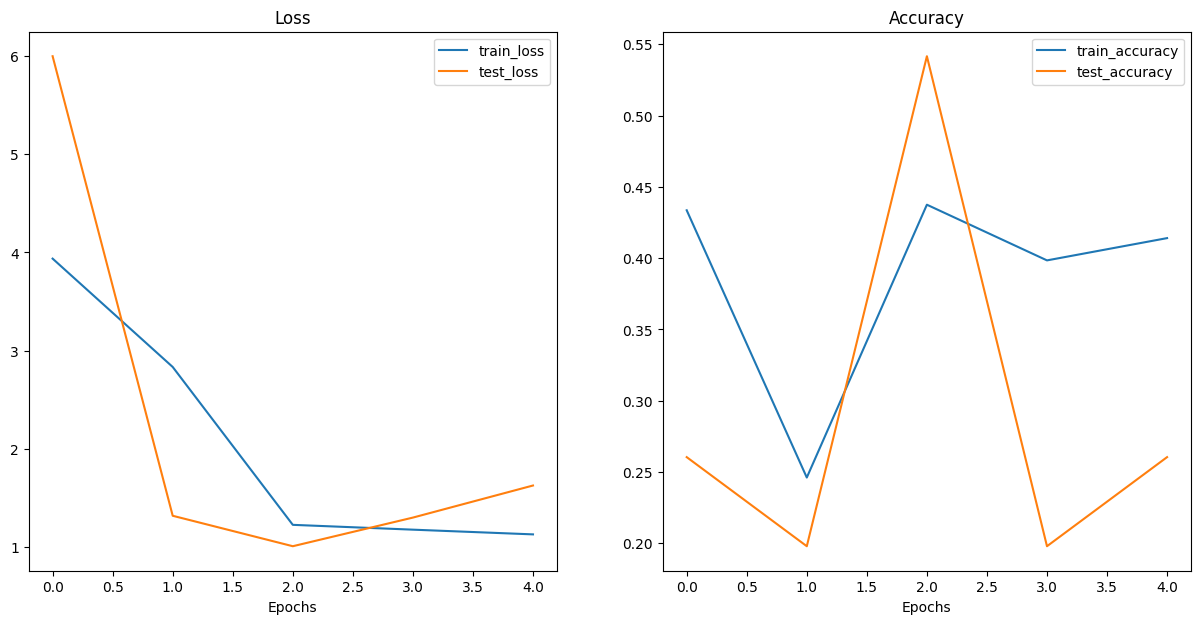

In [ ]:
import helper_functions

helper_functions.plot_loss_curves(results)

## 8. Using a pretrained ViT

In [ ]:
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

vit_pretrained = torchvision.models.vit_b_16(weights=vit_weights).to(device)
summary(model=vit_pretrained,
        input_size=(32, 3, 224, 224), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 179MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [ ]:
for param in vit_pretrained.parameters():
  param.requires_grad = False

torch.manual_seed(42)

vit_pretrained.heads = nn.Linear(in_features=768,
                  out_features=len(class_names))

summary(model=vit_pretrained,
        input_size=(32, 3, 224, 224), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

### 8.1 Preparing data for the pretrained ViT

In [ ]:
# Get automatic transforms from pretarined ViT weights
vit_transforms = vit_weights.transforms()

train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=BATCH_SIZE # could set the batch size higher because of the pretrained model
)

### 8.2 Train feature extrator ViT model

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8004 | train_acc: 0.7188 | test_loss: 0.5359 | test_acc: 0.8873
Epoch: 2 | train_loss: 0.3795 | train_acc: 0.9336 | test_loss: 0.3586 | test_acc: 0.9081
Epoch: 3 | train_loss: 0.3807 | train_acc: 0.8242 | test_loss: 0.2504 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.1866 | train_acc: 0.9531 | test_loss: 0.2650 | test_acc: 0.8883
Epoch: 5 | train_loss: 0.1991 | train_acc: 0.9570 | test_loss: 0.2721 | test_acc: 0.8883
Epoch: 6 | train_loss: 0.3232 | train_acc: 0.8398 | test_loss: 0.2785 | test_acc: 0.8883
Epoch: 7 | train_loss: 0.1303 | train_acc: 0.9727 | test_loss: 0.2675 | test_acc: 0.8987
Epoch: 8 | train_loss: 0.1338 | train_acc: 0.9766 | test_loss: 0.2357 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.1012 | train_acc: 0.9844 | test_loss: 0.2095 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.0951 | train_acc: 0.9805 | test_loss: 0.2042 | test_acc: 0.9280


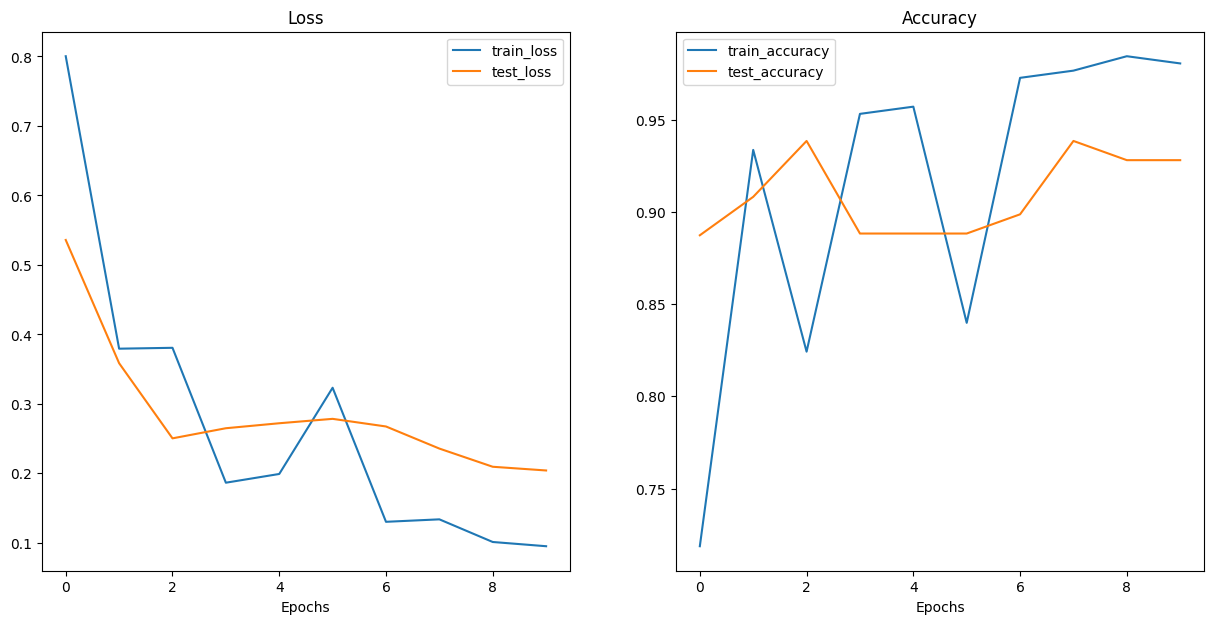

In [ ]:
optimizer = torch.optim.Adam(
  vit_pretrained.parameters(),
  lr=1e-3,
  betas=(0.9,0.999),
  weight_decay=0.1
)

# Loss function is not mentioned, we assume
loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(
    model = vit_pretrained,
    train_dataloader = train_dataloader_pretrained,
    test_dataloader = test_dataloader_pretrained,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = 10,
    device=device,
    writer=None
)

helper_functions.plot_loss_curves(results)

### 8.3 Save the pretrained model

In [ ]:
import utils
save_filepath = f"08_vit_pretrained.pth"
utils.save_model(model=vit_pretrained,
                 target_dir="/content/drive/MyDrive/colab_copilot_data/08/models",
                 model_name=save_filepath)

[INFO] Saving model to: /content/drive/MyDrive/colab_copilot_data/08/models/08_vit_pretrained.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("/content/drive/MyDrive/colab_copilot_data/08/models/08_vit_pretrained.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


The pretrained ViT gets some of the best results we've seen so far on the FoodVision Mini problem, however, the model size is ~11x larger than our previous best performing model.

Perhaps the larger model size might cause issues when we go to deploy it., e.g. hard to depploy such a large file or might not make predictions as fast as a smaller model.

## 9. Predict on the custom image

/content/drive/MyDrive/colab_copilot_data/04/data/04-pizza.jpeg


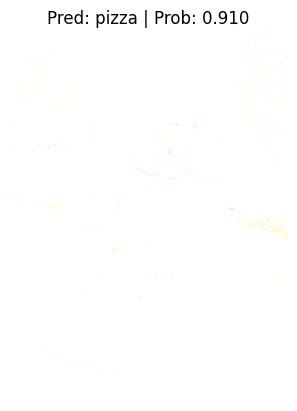

In [ ]:
custom_image_path = data_path / "04-pizza.jpeg"
print(custom_image_path)

# Predict on custom image
helper_functions.pred_and_plot_image(model=vit_pretrained,
                    image_path=custom_image_path,
                    class_names=class_names,
                                     transform=v2.Resize(size=(224,224)))